In [2]:
# %run modules.ipynb
import numpy as np
from math import *
import random
import itertools
from scipy.optimize import root
from scipy import stats
from scipy import special
import copy
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import pickle
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
Nr = 4
preference_list = list(itertools.permutations(range(Nr), Nr))

In [ ]:
# PLOTTING SETTINGS

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15
WIDTH = 500 # could modify later

from matplotlib import gridspec
#from brokenaxes import brokenaxes
import os

plt.rc('font', size=15, family='sans-serif', serif='Arial') # controls default text sizes
plt.rc('lines', linewidth=2) # make lines thicker
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize = 15)

def set_size(width, scale=1, fraction = 1):
    # Width of figure (in pts)
    fig_width_pt = width * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / fraction

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

### Note that due to file size limits, the data used here is a small subset of all simulated data, therefore the results have a larger errorbar. 
(From RunsWithLags.py, one can generate as many data as wanted. To analyze such data, the "inputFileName" and "outputFileName" parts in the next block needs to be modified.) 

In [7]:
# LOAD THE DATA

Size = 480
import os
allInputs2 = []
allOutputs2 = []
invasionOrdersTime2 = []
for Nr in [4]:
    allInputs2.append([])
    allOutputs2.append([])
    for folder in range(1, 8):
        for index in range(1, 101):
            outputFileName = 'example data\dir_'+str(folder)+'\outputs_Nr='+str(Nr)+'_index='+str(index)+'_balanced.pkl'
            inputFileName = 'example data\dir_'+str(folder)+'\input_Nr='+str(Nr)+'_index='+str(index)+'_balanced.pkl'
            if os.path.exists(outputFileName) and os.path.exists(inputFileName) and os.stat(outputFileName).st_size != 0: 
                inputs = pickle.load(open(inputFileName, "rb" ))
                allInputs2[-1].append(inputs)
                outputs = pickle.load(open(outputFileName, "rb" ))
                allOutputs2[-1].append(outputs)
        
n_reentrance = []
n_all = []
for Nr in range(len([4])):
    invasionOrdersTime2.append([])
    n_reentrance.append(0)
    n_all.append(0)
    for index in range(len(allOutputs2[Nr])):
        invasionOrdersTime2[-1].append([])
        n_all[-1] += 1
        for j in allOutputs2[Nr][index]['details'][-1]:
            if(invasionOrdersTime2[-1][-1] == [] or allInputs2[Nr][index]['invlist'].index(j) > max(invasionOrdersTime2[-1][-1])):
                invasionOrdersTime2[-1][-1].append(allInputs2[Nr][index]['invlist'].index(j))
            else:
                invasionOrdersTime2[-1][-1].append(allInputs2[Nr][index]['invlist'].index(j) + factorial(4)*Size)
                n_reentrance[-1] += 1
                
removed = [i for i in range(len(allOutputs2[-1])) if invasionOrdersTime2[-1][i][0] != 0]
allOutputs2[-1] = [allOutputs2[-1][i] for i in range(len(allOutputs2[-1])) if i not in removed]
allInputs2[-1] = [allInputs2[-1][i] for i in range(len(allInputs2[-1])) if i not in removed]
invasionOrdersTime2[-1] = [invasionOrdersTime2[-1][i] for i in range(len(invasionOrdersTime2[-1])) if i not in removed]

allInputs = allInputs2
allOutputs = allOutputs2
invasionOrdersTime = invasionOrdersTime2

### Figure. 2

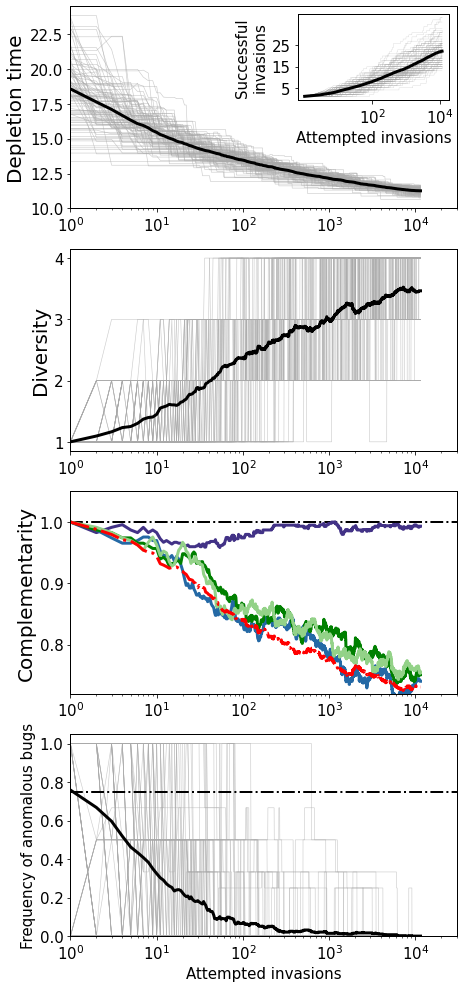

In [9]:
Nr = 4
Size = 480
preference_list = list(itertools.permutations(range(Nr), Nr))
colors = ['#423286ff', '#2469a5ff', '#008000ff', '#93d288']


def slotsEvaluation(slotcuts, axis, xs, func, spaghettis = True, errorbar = True, align = 'center', **kwargs_of_func): # given the data and the slots, return the spaghetti plot and the errorbar plot created by x-slots.
    global kwargs_of_spaghetti
    global kwargs_of_errorbar
    # generate the ycoordinates and do the spaghetti plots
    plt.sca(axis)
    ys = [func(xcoords_idx, xcoords, **kwargs_of_func) for xcoords_idx, xcoords in enumerate(xs)]    
    
    xs = [[xs[i][j] for j in range(len(xs[i])) if xs[i][j] == min(xs[i][j:])] for i in range(len(xs))]
    ys = [[ys[i][j] for j in range(len(xs[i]))] for i in range(len(xs))]
    
    #process xs and ys
    xnews = []
    ynews = []
    xsMax = 480*24
    
    for xcoords_idx, xcoords in enumerate(xs):
        for i in range(1, len(xcoords)):
            if(xcoords[i] < xcoords[i-1]): xcoords[i] += Size * factorial(Nr)
        xcoord_new = list(range(xcoords[0], xsMax+1))
        ycoord_new = []
        xnews.append(xcoord_new)
        markers = [i for i in xcoords if i < xsMax] + [xsMax]
        if(xsMax in xcoords):
            ymarkers = list(ys[xcoords_idx][:xcoords.index(xsMax)+1])
        else:
            ymarkers = list(ys[xcoords_idx][:xcoords.index(markers[-2])+1]) + [ys[xcoords_idx][xcoords.index(markers[-2])]]
        slots = [markers[i+1]-markers[i] for i in range(len(markers)-1)]
        for idx, i in enumerate(slots):
            for i in range(i):
                ycoord_new.append(ymarkers[idx])
        ycoord_new.append(ymarkers[-1])
        ynews.append(ycoord_new)
    xs = xnews
    ys = ynews
    
    if spaghettis == True:
          for idx in range(100):
            plt.plot(xs[idx], ys[idx], **kwargs_of_spaghetti)
            
    # get the stats and do a average +- SEM
    ycoordInSlots = [[] for i in range(min(i[0] for i in xs), min(i[0] for i in xs) + max([len(i) for i in ys]))]
    for y in ys:
        for idx, i in enumerate(y):
            ycoordInSlots[idx].append(i)
    thickMeans = [np.mean(i) for i in ycoordInSlots]
    thickSEMs = [np.std(i)/sqrt(len(i)) for i in ycoordInSlots]
    y1 = [i+j for i, j in zip(thickMeans, thickSEMs)]
    y2 = [i-j for i, j in zip(thickMeans, thickSEMs)]
    xout = range(min(i[0] for i in xs), min(i[0] for i in xs) + max([len(i) for i in ys]))[:-50]
    yout = thickMeans[:-50]
    if errorbar == True:
        plt.fill_between(range(min(i[0] for i in xs), min(i[0] for i in xs) + max([len(i) for i in ys]))[:-50], y1[:-50], y2[:-50], where=(y1 > y2), alpha =  0.3, **kwargs_of_errorbar)
        plt.errorbar(range(min(i[0] for i in xs), min(i[0] for i in xs) + max([len(i) for i in ys]))[:-50], thickMeans[:-50], yerr = None, alpha = 1, **kwargs_of_errorbar)
    else: 
        plt.errorbar(range(min(i[0] for i in xs), min(i[0] for i in xs) + max([len(i) for i in ys]))[:-50], thickMeans[:-50], yerr = None, **kwargs_of_errorbar) 
    return xout, yout

fig = plt.figure(constrained_layout=True, figsize = set_size(WIDTH, fraction=0.25))
gs = gridspec.GridSpec(4, 1)
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

# first create the global slots for all the time series data
d = 1.5
gap = 5
summed = 0
slots = []
thrs = [2]
while(summed < max([i[-2] for i in invasionOrdersTime[-1]])):
    gap = gap*d
    summed += gap
    thrs.append(summed)
    slots.append([])
thrs = [0] + thrs[:-1]
thrs.append(24*480)
thrs.append(max([i[-2] for i in invasionOrdersTime[-1]])) 
xs = []
for outputidx, output6 in enumerate(allOutputs[-1]):
    xs0 = [i + 1 for i in invasionOrdersTime[-1][outputidx][:-1]]
    if(xs0[0] == 1):
        xs.append(xs0)

# the efficiencies
def efficiencies(xcoords_idx, xcoords, outputsDataset):
    detailsData = outputsDataset[xcoords_idx]['details']
    return [i*2 for i in [sum(i) for i in detailsData[3]][:-1]]
    
kwargs_of_spaghetti = {'color': '#A9A9A9', 'alpha': 0.6, 'linewidth': 0.6}
kwargs_of_errorbar = {'color': 'k', 'linewidth': 3}
xout1, yout1 = slotsEvaluation(thrs, ax1, xs, efficiencies, spaghettis = True, errorbar = False, outputsDataset = allOutputs[-1])
ax1.set_ylabel("Depletion time", fontsize = 20) 
ax1.set_xscale('log')
ax1.set_xlim([1, 3e4])

# the attempted vs. successful invasions
def successfulInvasions(xcoords_idx, xcoords, outputTimeDataset):
    return range(1, 1+len(outputTimeDataset[xcoords_idx]))[:-1]

axins1 = inset_axes(ax1, width=2.1, height=1.2)
kwargs_of_spaghetti = {'color': '#A9A9A9', 'alpha': 0.6, 'linewidth': 0.3}
kwargs_of_errorbar = {'color': 'k', 'linewidth': 3}
slotsEvaluation(thrs, axins1, xs, successfulInvasions, spaghettis = True, errorbar = False, outputTimeDataset = invasionOrdersTime[-1])
axins1.set_xscale('log')
axins1.set_xticks([1e2, 1e4])
axins1.set_yticks([5, 15, 25])
axins1.tick_params(axis='both', which='major', labelsize=15)
axins1.set_xlabel('Attempted invasions', fontsize = 15)
axins1.set_ylabel('Successful\ninvasions', fontsize = 15)

# the diversities
def diversities(xcoords_idx, xcoords, outputsDataset, Measure, N):
    data = outputsDataset[xcoords_idx]['details'][-2]
    return [Measure(snapshot[-1][:min(N, len(snapshot[-1]))]) for snapshot in data][:-1]

# this is the diversity measured in inverse simpsons index
def simpsonEvenness(L):
    normalizedL  = [i/sum(L) for i in L]
    return 1/(sum([i**2 for i in normalizedL]))
# this is the diversity measured in number of species
def Nspecies(L):
    return len(L)

kwargs_of_spaghetti = {'color': '#A9A9A9', 'alpha': 0.6, 'linewidth': 0.6}
kwargs_of_errorbar = {'color': 'k', 'linewidth': 3}
xout2, yout2 = slotsEvaluation(thrs, ax2, xs, diversities, spaghettis = True, errorbar = False, outputsDataset = allOutputs[-1], Measure = Nspecies, N=Nr)
ax2.set_xscale('log')
ax2.set_ylabel('Diversity', fontsize = 20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlim([1, 3e4])

# the complementarity
def upgradedUnikTopChoices(L, N):
    randomE = (1 - (1-1/N)**float(len(L))) * N / len(L)
    return (len(set(L)) / len(L)) / randomE

def upgradedUnikTopChoicesRaw(L, N):
    return (len(set(L)) / len(L))

def Nullcompl(L, N):
    randomE = (1 - (1-1/N)**float(len(L))) * N / len(L)
    return 1 / randomE

def NullCompl(L, N):
    randomE = (1 - (1-1/N)**float(len(L))) * N / len(L)
    return randomE

def compls(xcoords_idx, xcoords, outputsDataset, consumeOrder, complMeasure, Nnuts):
    data = outputsDataset[xcoords_idx]['details']
    return [complMeasure([preference_list[j // Size][consumeOrder] for j in i], Nnuts) for i in data[1][-len(xcoords)-1:-1]]

xsCompl=[[i-1 for i in j] for j in xs]
        
ys = []  
order = 0
for idx, x in enumerate(xsCompl):
    if(x != []):
        start = invasionOrdersTime[-1][idx].index(x[0])
        y = allOutputs[-1][idx]['details'][1][start:-1]
        y = [[preference_list[j // Size][order] for j in i] for i in y]
        ys.append([upgradedUnikTopChoicesRaw(i, Nr) for i in y])
        
ys_1 = []
order = 1
for idx, x in enumerate(xsCompl):
    if(x != []):
        start = invasionOrdersTime[-1][idx].index(x[0])
        y = allOutputs[-1][idx]['details'][1][start:-1]
        y = [[preference_list[j // Size][order] for j in i] for i in y]
        ys_1.append([upgradedUnikTopChoicesRaw(i, Nr) for i in y])
        
ys_2 = []
order = 2
for idx, x in enumerate(xsCompl):
    if(x != []):
        start = invasionOrdersTime[-1][idx].index(x[0])
        y = allOutputs[-1][idx]['details'][1][start:-1]
        y = [[preference_list[j // Size][order] for j in i] for i in y]
        ys_2.append([upgradedUnikTopChoicesRaw(i, Nr) for i in y])
        
ys_3 = []
order = 3
for idx, x in enumerate(xsCompl):
    if(x != []):
        start = invasionOrdersTime[-1][idx].index(x[0])
        y = allOutputs[-1][idx]['details'][1][start:-1]
        y = [[preference_list[j // Size][order] for j in i] for i in y]
        ys_3.append([upgradedUnikTopChoicesRaw(i, Nr) for i in y])
        
ysRnd = []  
order = 0
for idx, x in enumerate(xsCompl):
    if(x != []):
        start = invasionOrdersTime[-1][idx].index(x[0])
        y = allOutputs[-1][idx]['details'][1][start:-1]
        y = [[preference_list[j // Size][order] for j in i] for i in y]
        ysRnd.append([NullCompl(i, Nr) for i in y])
        
def Partcompl(xcoords_idx, xcoords, listname):
    return listname[xcoords_idx]
        
ax3.axhline(1, color = 'k', linestyle = '-.', label = 'Fully complementary')
xsCompl = [[i+1 for i in j] for j in xsCompl]
kwargs_of_spaghetti = {'color': '#A9A9A9', 'alpha': 0.6, 'linewidth': 0.6}
kwargs_of_errorbar = {'color': colors[0], "label": 'Top choice', 'linewidth': 3} #, 'linestyle': 'none', 'marker': 'o', 'markersize': 10,  'mfc': 'none'}
xout3, yout3 = slotsEvaluation(thrs, ax3, xsCompl, Partcompl, align = 'leftedge', spaghettis = False, errorbar = False, listname = ys)
kwargs_of_errorbar = {'color': colors[1], "label": 'Second choice', 'linewidth': 3}#,'linestyle': 'none', 'marker': 'o', 'markersize': 10,  'mfc': 'none'}
slotsEvaluation(thrs, ax3, xsCompl, Partcompl, align = 'leftedge', spaghettis = False, errorbar =False, listname = ys_1)
kwargs_of_errorbar = {'color': colors[2], "label": 'Third choice', 'linewidth': 3}#,'linestyle': 'none', 'marker': 'o', 'markersize': 10,  'mfc': 'none'}
slotsEvaluation(thrs, ax3, xsCompl, Partcompl, align = 'leftedge', spaghettis = False, errorbar = False, listname = ys_2)
kwargs_of_errorbar = {'color': colors[3], "label": 'Fourth choice', 'linewidth': 3}
slotsEvaluation(thrs, ax3, xsCompl, Partcompl, align = 'leftedge', spaghettis = False, errorbar = False, listname = ys_3)
kwargs_of_errorbar = {'color': 'r', "label": 'Without selection', 'linewidth': 3, 'linestyle': '-.'}
slotsEvaluation(thrs, ax3, xsCompl, Partcompl, align = 'leftedge', spaghettis = False, errorbar = False, listname = ysRnd)
ax3.set_xscale('log')
ax3.set_xlim(1, 3e4)
ax3.set_ylim(0.72, 1.05)
ax3.set_ylabel('Complementarity', fontsize = 20)

d = 1.5
gap = 10
summed = 0
slots = []
thrs = [1, 2, 3, 5]
while(summed < max([i[-2] for i in invasionOrdersTime[-1]])):
    gap = gap*d
    summed += gap
    thrs.append(summed)
    slots.append([])
thrs = thrs[:-1]
thrs = [0] +thrs

def isFreak(growth_rate_list, bug):
    Nb = len(growth_rate_list)
    Nr = len(growth_rate_list[0])
    if growth_rate_list[bug][int(bug//(Nb/Nr))] != max(growth_rate_list[bug]):
        return True
    return False

def fracAnomaly(xcoords_idx, xcoords, outputsDataset, inputsDataset):
    survivors = outputsDataset[xcoords_idx]['details'][1][:-1]
    survivorSnapshot = survivors[-1]
    return [sum([isFreak(inputsDataset[xcoords_idx]['G'], bug) for bug in survivorSnapshot]) / len(survivorSnapshot) for survivorSnapshot in survivors]

kwargs_of_spaghetti = {'color': '#A9A9A9', 'alpha': 0.6, 'linewidth': 0.6}
kwargs_of_errorbar = {'color': 'k', 'linewidth': 3}
xout4, yout4 = slotsEvaluation(thrs, ax4, xs, fracAnomaly, spaghettis = True, errorbar = False, align = 'leftedge', outputsDataset = allOutputs[-1], inputsDataset = allInputs[-1])
ax4.set_xscale('log')
ax4.set_ylim(0, 1.05)
ax4.set_xlim(1, 3e4)
ax4.set_xlabel('Attempted invasions')
ax4.set_ylabel('Frequency of anomalous bugs')
ax4.axhline(0.75, color = 'k', linestyle = '-.')

### Figure 3 (c) and (d)

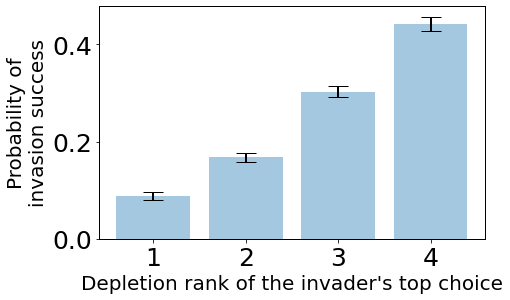

In [11]:
watershed = 150 
# Only consider invasion events after this many trials of invasions. 

def Topchoice(bug, idx, Nr):
    return allInputs[-1][idx]['G'][bug][preference_list[bug // Size][0]]
    
fig = plt.figure(constrained_layout=True, figsize = set_size(WIDTH, fraction=1))
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
NutrientsClaimed = [[0 for j in range(Nr)] for i in range(len(allOutputs[-1]))]
NutrientsUnclaimed = [[0 for j in range(Nr)] for i in range(len(allOutputs[-1]))]
for outputidx, case in enumerate(allOutputs[-1]):
    for idx, order in enumerate(case['details'][2][:-1]):
        if(invasionOrdersTime[-1][outputidx][idx] > watershed):
            ClaimingStatus = [preference_list[bug // Size][0] for bug in case['details'][1][idx]]
            for i in range(Nr):
                if case['details'][-1][idx+1] // (Size*factorial(Nr-1)) == i:
                    if(i in ClaimingStatus):
                        NutrientsClaimed[outputidx][order.index(i)] += 1
                    else:
                        NutrientsUnclaimed[outputidx][order.index(i)] += 1
                        
allfreq = [[i+j for i, j in zip(k, l)] for k, l in zip(NutrientsClaimed, NutrientsUnclaimed)]
allfreq = [[j/sum(i) for j in i] for i in allfreq]
allfreq = [[j[i] for j in allfreq] for i in range(Nr)]
allfreq_mean = [np.mean(i) for i in allfreq]
allfreq_sem =[np.std(i)/sqrt(len(i)) for i in allfreq]
claimed = [sum([i[j] for i in NutrientsClaimed]) for j in range(Nr)]

ax1.bar(range(1, Nr+1), allfreq_mean, yerr = allfreq_sem, error_kw=dict(lw=2, capsize=10, capthick=1), alpha = 0.4)
ax1.set_xlabel('Depletion rank of the invader\'s top choice', fontsize=20)
ax1.set_ylabel('Probability of\ninvasion success', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=25)

<ipython-input-13-9f6679ba7422>:66: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim([0, 3e4])


Text(0, 0.5, 'Growth rates of invaders')

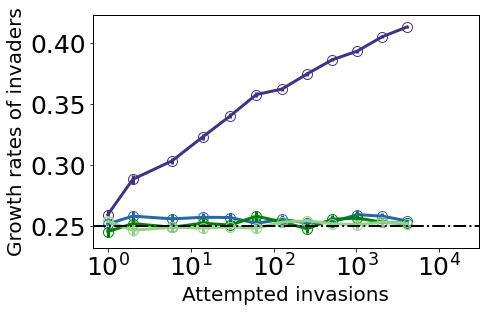

In [13]:
fig = plt.figure(constrained_layout=True, figsize = set_size(WIDTH))
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0]) 

# get logarithmically separated time slots. 
d = 2
gap = 1
summed = 0
slots = []
thrs = []
while(summed < max([i[-2] for i in invasionOrdersTime[-1]])):
    gap = gap*d
    summed += gap
    thrs.append(summed)
    slots.append([])
thrs = [0] + thrs[:-2]
xs = []
for outputidx, output6 in enumerate(allOutputs[-1]):
    xs.append([i + 1 for i in invasionOrdersTime[-1][outputidx][:-1]])
    
def gChoice(xcoords_idx, outputsDataset, order):
    invaders = []
    topChoices = []
    dataDetails = outputsDataset[xcoords_idx]['details']
    dataLen = len(dataDetails[1])
    for step in range(dataLen)[:-1]:
        invader = dataDetails[-1][step+1]
        invadedRes = preference_list[invader // Size][order]
        invaders.append(invader)
        topChoices.append(invadedRes)
    return [allInputs[-1][xcoords_idx]['G'][invader][topChoice]/2 for invader, topChoice in zip(invaders, topChoices)]
    
kwargs_of_errorbar = [{'marker': 'o', 'markersize': 10 , 'mfc': 'none', 'color': i,'linewidth': 3} for i in colors]
    
for order in range(Nr):
    slotcuts = thrs
    ys = [gChoice(xcoords_idx, allOutputs[-1], order) for xcoords_idx, xcoords in enumerate(xs)]
   
    firstInvaders = [i['details'][1][0][0] for i in allOutputs[-1]]
    initials = [allInputs[-1][xcoords_idx]['G'][invader][preference_list[invader // Size][order]]/2 for xcoords_idx, invader in enumerate(firstInvaders)]
    ycoordInSlots = [initials]
    for slotidx, slotbegin in enumerate(slotcuts[:-1]):
        ycoordInSlots.append([])
        slotend = slotcuts[slotidx + 1]
        for xcoords_idx, xcoords in enumerate(xs):
            for idx, i in enumerate(xcoords):
                if(slotbegin <= i < slotend):
                    ycoordInSlots[-1].append(ys[xcoords_idx][idx])
    thickMeans = [np.mean(i) for i in ycoordInSlots]
    thickSEMs = [np.std(i)/sqrt(len(i)) for i in ycoordInSlots]
    plt.errorbar([1] + [slotcuts[i+1] for i in range(len(slotcuts) - 1)], thickMeans, yerr = thickSEMs, zorder = 1, **kwargs_of_errorbar[order])
    if(order == 0):
        xout = [1] + [slotcuts[i+1] for i in range(len(slotcuts) - 1)]
        yout = thickMeans
        yerrout = thickSEMs
        
ax1.axhline(0.25, ls = '-.', color = 'k')
ax1.set_xscale('log')
ax1.set_xlim([0, 3e4])
ax1.set_xticks([1, 10, 100, 1000, 10000])
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.set_xlabel('Attempted invasions', fontsize=20)
ax1.set_ylabel('Growth rates of invaders', fontsize=20)